# The Anatomy of the Transformers Model Class

🤗Transformers is organized around dedicated classes for each architecture and task. The model classes associated with different tasks and named according to a `<ModelName>For<Task>` convention, or `AutoModelFor<Task>` when using the `AutoModel` classes.

🤗Transformers is designed to enable you to easily extend existing models for your specific use case. You can load the weights from pretrained models, and you have access to task-specific helper functions. This lets you build custom models for specific objectives with very little overhead.

## Bodies and Heads

The main concept that makes 🤗Transformers so versatile is the split of the architecture into a *body* and *head*. We just need to replace the last layer of the model with one that is suitable for the task. This last layer is called the model head; it's the part that is *task-specific*. The rest of the model is called the body; it includes the token embeddings and transformer layers that are *task-agnostic*. This structure is reflected in the 🤗Transformers code as well: the body of a model is implemented in a class such as `BertModel` or `GPT2Model` that returns the hidden states of the last layer. Task-specific models such as `BertForMaskedLM` or `BertForSequenceClassification` use the base model and add the necessary head on top of the hidden states, as shown the figure below.

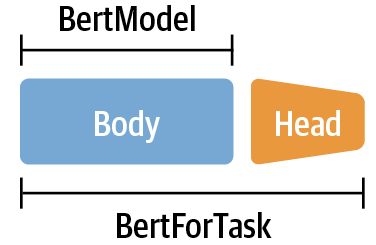

## Creating a Custom Model for Token Classification

Let's go through the exercise of building a custom token classification head for XLM-R. Since XLM-R uses the same model architectur as RoBERTa, we will use RoBERTa as the base model, but augmented with settings specific to XLM-R. FOr token classification, an `XLMRobertaForTokenClassification` class already exists that you can import from 🤗Transformers.

In [2]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict
from torch import nn
from transformers import XLMRobertaConfig, AutoTokenizer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [3]:
# the dataset
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

tags = panx_ch["de"]["train"].features["ner_tags"].feature
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)
de_example = panx_de["train"][0]

In [4]:
# tokenizer
text = "Jack Sparrow loves New York!"
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")    
xlmr_tokens = xlmr_tokenizer(text).tokens()
print(xlmr_tokens)

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [5]:
# defining a custom model
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # use model body to get encoder representations
        outputs = self.roberta(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               **kwargs)
        # apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # return model output object
        return TokenClassifierOutput(loss=loss,
                                     logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)        

## Loading a Custom Model

In [6]:
from transformers import AutoConfig

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

xlmr_config = AutoConfig.from_pretrained("xlm-roberta-base",
                                         num_labels = tags.num_classes,
                                         id2label = index2tag,
                                         label2id = tag2index)

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", config=xlmr_config).to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import pandas as pd

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [9]:
# We need to pass the inputs to the model and extract the predictions by taking the argmax to get the most likely class per token:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [10]:
# Here we see that the logits have the shape [batch_size, num_tokens, num_tags],
# with each token given a logit among the seven possible NER tags.
# Unsurprisingly, our token classification layer with random weights leaves a lot to be desired:
# let's fine-tuning on some labeled data to make it berrter.
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,I-PER,I-PER,I-ORG,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER


In [11]:
# Wrap the preceding steps into a helper function
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    # encode the sentence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

# Tokenizing Texts for NER

Next step is to tokenize the whole dataset so that we can pass it to the XLM-R model for fine-tuning.

In [12]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [13]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [14]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [15]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [16]:
# let's scale this out to the whole dataset by defining a single function that wrap all the logic:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"],
                                      truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [17]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

In [18]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

# Performance Measures

Evaluating a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1-score. The only subtlety is that *all* words of an entity need to be predicted correctly in order for a prediction to be counted as correct. Fortunately, there is a nifty library called `seqeval` that is designed for these kinds of tasks.

In [19]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [20]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-Tuning XLM-RoBERTa

In [21]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = "xlm-roberta-base-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=False, no_cuda=True)

In [22]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [23]:
from transformers import DataCollatorForTokenClassification

# define a data collator so we can pad each input sequence to the largest sequence length in a batch.
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [24]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", config=xlmr_config).to(device))

In [25]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer)

In [26]:
trainer.train()

/Users/changjun/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1575 [00:00<?, ?it/s]

In [27]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# Error Analysis

In [28]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    # unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss": loss, "predicted_label": predicted_label}

valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

Parameter 'function'=<function forward_pass_with_label at 0x301f28820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.081782825, 0.0, 0.059728663, 0.0463237...","[O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [29]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.08,B-ORG,▁Ham
0,15,1,I-ORG,0.06,I-ORG,▁(
0,16104,1,I-ORG,0.05,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.07,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.90,B-ORG,▁Luz
1,10,1,I-ORG,0.42,I-ORG,▁a


In [30]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁von,▁der,▁(,▁),▁in,▁/,▁und,▁'',▁A
count,6066,808,1388,246,246,989,163,1171,2898,125
mean,0.05,0.18,0.09,0.44,0.43,0.1,0.55,0.08,0.03,0.5
sum,315.35,148.27,127.37,109.08,105.77,103.07,89.43,87.93,78.07,62.04


In [31]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-PER,I-PER,B-LOC,O
count,2683,1462,3820,2893,4139,3172,43648
mean,0.74,0.71,0.57,0.32,0.21,0.2,0.05
sum,1981.84,1034.4,2165.89,936.02,874.77,632.29,2276.25


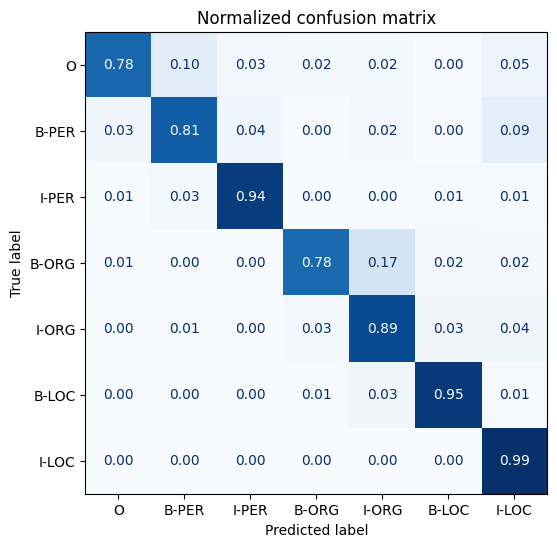

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [34]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.79,0.00,0.00,0.00,9.44,10.76,8.89,9.71,9.52,0.00,9.87,9.18,0.00,9.56,9.11,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.44,0.00,0.00,2.92,8.03,7.33,3.47,0.00,6.26,7.29,4.89,2.93,3.48,0.00,0.00,0.02,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,B-LOC,I-LOC,I-LOC,O
losses,4.78,4.57,4.90,0.00,4.64,0.00,4.57,0.00,4.31,3.90,4.47,4.71,4.38,4.57,0.00


In [35]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,0.08,0.00,0.06,0.05,0.07,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O
losses,0.03,0.00,0.00,0.04,0.04,0.00,0.04,0.00
